# Topic Classification

In this project, we will work with text data from newsgroup postings on a variety of topics. We will train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction:
http://scikit-learn.org/stable/modules/feature_extraction.html



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from sklearn import preprocessing
#from sklearn.feature_extraction import SelectPercentile

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[677:], newsgroups_test.target[677:]
dev_data, dev_labels = newsgroups_test.data[:676], newsgroups_test.target[:676]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (676,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
# P1():

# Considering only five example data
for text in range(len(train_data[:5])):
    
    #print label
    print('Label = ', train_labels[text])
    #print example text
    print(train_data[:text])

#P1(2)

Label =  1
[]
Label =  3
["Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych"]
Label =  2
["Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is n

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
#P2:

##Convert the raw training text into feature vectors##
cv = CountVectorizer()
train_cv = cv.fit_transform(train_data)
#print(train_cv)
train_cv.toarray()
#dev_cv = cv.transform(dev_data)
#print(train_cv.toarray())

#print(train_cv.shape, dev_cv.shape)



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [5]:
#P2.a

##Size of vocabulary##

print("Size of the vocabulary is:", train_cv.shape[1])


#Get total count and average count of non-zero features

def count_nonzero(feature_vector):    
    count_nnz = 0
    avg_nnz = 0
    for example in range(feature_vector.shape[0]):
        count_nnz = count_nnz + feature_vector[example].nnz
    avg_nnz = round((count_nnz/feature_vector.shape[0]), 5)
    return[count_nnz, avg_nnz]

#Divide total non-zero entry by total matrix entry
def frac_nonzero(feature_vector, total_nonzero):
    total_entry = feature_vector.shape[0]*feature_vector.shape[1]
    frac_nonzero = round(total_nonzero/total_entry,5)
    return frac_nonzero

##Average Number of non-zero features##

count_nnz = count_nonzero(train_cv)
print("Size of the average non-zero per example is:", count_nnz[1])

##Fraction of non-zero entry in the feature matrix##

frac_nnz = frac_nonzero(train_cv, count_nnz[0])
print("Fraction of non-zero entry is:", frac_nnz)

#print("Total non-zero entry is:", count_nonzero(train_cv)[0])

Size of the vocabulary is: 26879
Size of the average non-zero per example is: 96.706
Fraction of non-zero entry is: 0.0036


In [6]:
###P2.b

feature_names = cv.get_feature_names()

##0-th feature of the string
print("0-th feature of the string is: ",feature_names[0])

##last feature of the string
print("Last feature of the string is: ",feature_names[len(feature_names)-1])

0-th feature of the string is:  00
Last feature of the string is:  zyxel


In [7]:
###P2.c

##Specify vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]

my_vocab = ["atheism", "graphics", "space", "religion"]

##Confirm the training vectors are appropriately shaped.
my_cv = CountVectorizer(vocabulary=my_vocab)
my_train_cv = my_cv.fit_transform(train_data)

##The average number of non-zero features per example
count_nnz = count_nonzero(my_train_cv)
print("Size of the average non-zero per example is:", count_nnz[1])

Size of the average non-zero per example is: 0.26844


In [8]:
###P2.d

##Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features.

#For extracting bigram and trigram character word features using ngram_rang = (2,3)
tv = TfidfVectorizer(analyzer = 'word', min_df= 1, stop_words= 'english', ngram_range=(2,3))
train_tv = tv.fit_transform(train_data)
#feature_tv = tv.get_feature_names()
#print(feature_tv[:20])
#cv1 = CountVectorizer()
#train_cv1 = cv1.fit_transform(train_data[:20])
#print(train_cv1)
#print('TfidfVectorizer = ',train_tv)
#print(train_cv1.toarray())
#print('hi')
#print(train_tv.toarray())
#feature_cv = cv1.get_feature_names()

##What size vocabulary does this yield?

#Define function to calculate vocabulary length

def vocab_length(feature_vector):
    return(len(feature_vector.vocabulary_))

print('The size of the vocabulary is: ', vocab_length(tv))


The size of the vocabulary is:  346592


In [9]:
###P2.e

##Use the "min_df" argument to prune words that appear in fewer than 10 documents.

tv_min_df = TfidfVectorizer(analyzer = 'word', min_df= 10)
train_tv_min_df = tv_min_df.fit_transform(train_data)

##What size vocabulary does this yield?

print('The size of the vocabulary where words appear in fewer than 10 documents is: ', vocab_length(tv_min_df))

The size of the vocabulary where words appear in fewer than 10 documents is:  3064


In [10]:
###P2.f

##f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary?
#Hint: build a vocabulary for both train and dev and look at the size of the difference.

#
# Calculate length of vocabulary in train_data

vocab_train_len = vocab_length(cv)
print('vocab_train_len = ',vocab_train_len)
# Calculate length of vocabulary in dev_data

cv_dev = CountVectorizer()
dev_cv = cv_dev.fit_transform(dev_data)
vocab_dev_len = vocab_length(cv_dev)
print('vocab_dev_len = ',vocab_dev_len)
# Calculate Difference in vocabulary length between train and dev

vocab_len_diff = vocab_train_len - vocab_dev_len
print('vocab_len_diff = ',vocab_len_diff)

# Calculate the fraction of the words in the dev data that are missing from the vocabulary

print('fraction of the words in the dev data that are missing from the vocabulary is:end= ', round(vocab_len_diff/vocab_train_len, 5))

vocab_train_len =  26879
vocab_dev_len =  16246
vocab_len_diff =  10633
fraction of the words in the dev data that are missing from the vocabulary is:end=  0.39559


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [11]:
### P3():
## Fit a K-nearest neighbor classifier ##

## Define prediction function for knn classifier ##
def prediction(k, train, labels, dev):
    neigh = KNeighborsClassifier(k)
    neigh.fit(train, labels)
    predict = neigh.predict(dev)
    return predict

## Define Function to calculate accuracy ##
def accuracy(predict, dev_labels):
    accurate, total = 0, 0
    for pred, label in zip(predict, dev_labels):
        if pred == label: accurate += 1
        total += 1
    return [total, accurate, round(1.0*accurate/total, 4)]

k_val = [1, 3, 5, 7, 9]
accu = 0
bestK = 0

# Using transform for dev_data instead of fit_transform as already it is fitted to train_data #
dev_data_cv = cv.transform(dev_data)

for k in k_val:
    predict = prediction(k, train_cv, train_labels, dev_data_cv)
    result = accuracy(predict, dev_labels)
    if result[2] > accu:
        #accu = result[2.0]
        bestK = k
print('Optimal value for K is: ', bestK)
    
pred = prediction(bestK, train_cv, train_labels, dev_data_cv)

actual = np.array(dev_labels)
#print(actual)
#print(metrics.classification_report(dev_labels, pred, target_names=newsgroups_train.target_names))
print("F1 score for KNN classifier when k = 9 is: ",f1_score(dev_labels, pred, average = 'macro'))

## Naive Bayes ##

mnb = MultinomialNB().fit(train_cv, train_labels)

# prepare a range of alpha values to test
alphas = np.array([0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0])

#Search for best alpha value

grid_mnb = GridSearchCV(estimator=mnb, param_grid=dict(alpha=alphas))
grid_mnb.fit(train_cv, train_labels)

# summarize the results of the grid search
print('best alpha value = ', grid_mnb.best_estimator_.alpha)
print('best score using Multinomial NB Classifier is: ', grid_mnb.best_score_)

## Logistic Regression ##

logit = LogisticRegression().fit(train_cv, train_labels)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_logit = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
grid_logit.fit(train_cv, train_labels)

print('best C value = ', grid_logit.best_estimator_.C)
print('best score using Logistic Regression is: ', grid_logit.best_score_)

#P3()

Optimal value for K is:  9
F1 score for KNN classifier when k = 9 is:  0.42330050510183215


/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/naive_ba

best alpha value =  0.01
best score using Multinomial NB Classifier is:  0.828416912487709


/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaco

best C value =  0.1
best score using Logistic Regression is:  0.7664700098328416


**ANSWER:**  
a) By extensive experimenting, through KNN clustering, consistency/ accuracy can be improved for predicting news group data. But due to overfitting, accuracy on predicting test data will not be that great.  
  
b) Naive Bayes is a generative model and so first models the joint distribution of the feature X and target Y; and then predicts the posterior probability given as P(y|x). Also it considers all the features to be conditionally independent.  
On the other hand, Logistic Regression is a discriminative model. So it directly models the posterior probabilty of P(y|x) by learning the input to output mapping. Also it splits feature space linearly and predict accuracy based on that.  
Because newgroup data consists of varieties of news or different types of text, features are not really correlated. And therefore Logistic Regression does not work as well as Naive Bayes does.  
  
c) In Logistic Regression, C value with minimum R-square is the best C value.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [12]:
## P4

# define a function to find the top n features with largest weights for each label#
def show_top_n(classifier, vectorizer, categories, n):
    feature_names = np.asarray(vectorizer.get_feature_names())
    feature_list = []
    top = []
    weight_aa = []
    weight_cg = []
    weight_ss = []
    weight_trm = []
    for i, category in enumerate(categories):
        top_n = np.argsort(classifier.coef_[i])[-n:]
        top.append(top_n)
        print('For Category: ''"%s"'', top five features are: '"%s" % (category, feature_names[top_n]))
        feature_list.append(feature_names[top_n])
        for j, cat in enumerate(categories):
            if cat == "alt.atheism":
                weight_aa.append(classifier.coef_[j][top_n])               
            elif cat == "comp.graphics":
                weight_cg.append(classifier.coef_[j][top_n])
            elif cat == "sci.space":
                weight_ss.append(classifier.coef_[j][top_n])
            elif cat == "talk.religion.misc":
                weight_trm.append((classifier.coef_[j])[top_n])

    return [feature_list, weight_aa, weight_cg, weight_ss, weight_trm]

logit_tv = LogisticRegression().fit(train_tv, train_labels)

#Call show_top_n function to show the top 5 features against each label#
show_feature_list = show_top_n(logit_tv, tv, newsgroups_train.target_names, 5)


# Create 20/4 table to display weight against each feature of the labels #

print(": Feature Name        : alt.atheism    : comp.graphics :  sci.space  : talk.religion.misc")
print("==========================================================================================")

for i in range(5):           
    print(":",show_feature_list[0][0][i]," "*(18 - len(show_feature_list[0][0][i])),
          ":",round(show_feature_list[1][0][i],6)," "*(13 - len(str(round(show_feature_list[1][0][i],6)))),
          ":",round(show_feature_list[2][0][i],6)," "*(12 - len(str(round(show_feature_list[2][0][i],6)))),
          ":",round(show_feature_list[3][0][i],6)," "*(10 - len(str(round(show_feature_list[3][0][i],6)))),
          ":",round(show_feature_list[4][0][i],6)," "*(10 - len(str(round(show_feature_list[4][0][i],6)))))

for i in range(5):           
    print(":",show_feature_list[0][1][i]," "*(18 - len(show_feature_list[0][1][i])),
          ":",round(show_feature_list[1][1][i],6)," "*(13 - len(str(round(show_feature_list[1][1][i],6)))),
          ":",round(show_feature_list[2][1][i],6)," "*(12 - len(str(round(show_feature_list[2][1][i],6)))),
          ":",round(show_feature_list[3][1][i],6)," "*(10 - len(str(round(show_feature_list[3][1][i],6)))),
          ":",round(show_feature_list[4][1][i],6)," "*(10 - len(str(round(show_feature_list[4][1][i],6)))))
    
for i in range(5):           
    print(":",show_feature_list[0][2][i]," "*(18 - len(show_feature_list[0][2][i])),
          ":",round(show_feature_list[1][2][i],6)," "*(13 - len(str(round(show_feature_list[1][2][i],6)))),
          ":",round(show_feature_list[2][2][i],6)," "*(12 - len(str(round(show_feature_list[2][2][i],6)))),
          ":",round(show_feature_list[3][2][i],6)," "*(10 - len(str(round(show_feature_list[3][2][i],6)))),
          ":",round(show_feature_list[4][2][i],6)," "*(10 - len(str(round(show_feature_list[4][2][i],6)))))
    
for i in range(5):           
    print(":",show_feature_list[0][3][i]," "*(18 - len(show_feature_list[0][3][i])),
          ":",round(show_feature_list[1][3][i],6)," "*(13 - len(str(round(show_feature_list[1][3][i],6)))),
          ":",round(show_feature_list[2][3][i],6)," "*(12 - len(str(round(show_feature_list[2][3][i],6)))),
          ":",round(show_feature_list[3][3][i],6)," "*(10 - len(str(round(show_feature_list[3][3][i],6)))),
          ":",round(show_feature_list[4][3][i],6)," "*(10 - len(str(round(show_feature_list[4][3][i],6)))))
    


For Category: "alt.atheism", top five features are: ['god tells' 'cheers kent' 'don think' 'alt atheism' 'promises broken']
For Category: "comp.graphics", top five features are: ['does anybody' 'does know' '24 bit' 'comp graphics' 'thanks advance']
For Category: "sci.space", top five features are: ['real life' 'space shuttle' 'nasa gov' 'sci space' 'space station']
For Category: "talk.religion.misc", top five features are: ['sure wrong' 'ignorance strength' 'cheers kent' 'objective morality'
 'jesus christ']
: Feature Name        : alt.atheism    : comp.graphics :  sci.space  : talk.religion.misc
: god tells           : 0.666817       : -0.2833       : -0.286589   : -0.149177  
: cheers kent         : 0.723716       : -0.742005     : -0.747503   : 0.809051   
: don think           : 0.777132       : -0.459338     : -0.25303    : -0.056463  
: alt atheism         : 0.809897       : -0.417891     : -0.418916   : 0.039521   
: promises broken     : 0.901168       : -0.382413     : -0.3859

ANSWER: Other than five top features in each label, co-efficients of other features are in negative values.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [13]:
### P5():

def my_preprocessor(data):

   #Lowercase characters
   data= data.lower()
   #Remove non-letter or non number characters
   data = re.sub("A-Za-z0-9 \\n"," ",data)
   #shorten long words to 6 characters max
   data=re.sub("(\w{%d})\w+" %6,"\\1",data)
   #replace sequence with number
   data = re.sub("([\d]+)"," number ",data)
   return data


# Print F1 score before processing the raw data
f1_original = logit.predict(dev_data_cv)
print("The size of dictionary on raw data: ", train_cv.shape[1] )
print("F1 score on Dev_data without any prior manipulation",f1_score(dev_labels, f1_original, average = 'macro'))


# Process raw data by calling pre-processor
processed_cv = CountVectorizer(preprocessor=my_preprocessor, stop_words='english')
processed_train_cv = processed_cv.fit_transform(train_data)
processed_dev_cv =processed_cv.transform(dev_data)
processed_logit_cv = LogisticRegression(penalty='l2')
processed_logit_cv.fit(processed_train_cv,train_labels)
f1_later = processed_logit_cv.predict(processed_dev_cv)
print("The size of dictionary after pre-processing: ", processed_train_cv.shape[1] )
print("f1 score with better preprocessor: ", metrics.f1_score(dev_labels,f1_later,average ='macro'))

The size of dictionary on raw data:  26879
F1 score on Dev_data without any prior manipulation 0.6793260443571856


/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterw', 'agains', 'alread', 'althou', 'amongs', 'amoung', 'anothe', 'anythi', 'anywhe', 'becaus', 'becomi', 'betwee', 'couldn', 'descri', 'elsewh', 'everyo', 'everyt', 'everyw', 'fiftee', 'furthe', 'hereaf', 'hereup', 'hersel', 'himsel', 'howeve', 'hundre', 'intere', 'meanwh', 'moreov', 'neithe', 'nevert', 'nothin', 'nowher', 'otherw', 'oursel', 'perhap', 'seemin', 'seriou', 'severa', 'sincer', 'someho', 'someon', 'someth', 'someti', 'somewh', 'themse', 'therea', 'thereb', 'theref', 'therei', 'thereu', 'throug', 'togeth', 'whatev', 'whenev', 'wherea', 'whereb', 'wherei', 'whereu', 'wherev', 'whethe', 'whithe', 'whoeve', 'withou', 'yourse'] not in stop_words.
  sorted(inconsistent))


The size of dictionary after pre-processing:  17512
f1 score with better preprocessor:  0.7193989758105468


**ANS:** I was able to reduce teh size of dictionary by 9357 points.  
F1 score increased by 0.04 points.

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

/Users/debalinamaiti/Documents/GraduateStudy/MIDS/Python_Bridge/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Number of non-zero weights for L1 regularization:  1814
Number of non-zero weights for L2 regularization:  107516
As number of samples where weight is  0 , not manipulating vocabulary size
Vocabulary size for dev data is:  16246


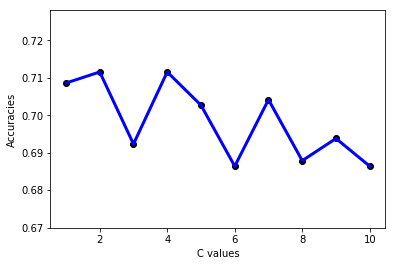

In [14]:
# def P6():
# Keep this random seed here to make comparison easier.
np.random.seed(0)

#Classifier using L1 penalty
logit_l1 = LogisticRegression(penalty='l1', tol=0.01, C=1).fit(train_cv, train_labels)
print('Number of non-zero weights for L1 regularization: ',np.count_nonzero(logit_l1.coef_ != 0))

#Classifier using L2 penalty
logit_l2 = LogisticRegression(penalty='l2', tol=0.01, C=1).fit(train_cv, train_labels)
print('Number of non-zero weights for L2 regularization: ',np.count_nonzero(logit_l2.coef_ != 0))

#Reduce vocab size keeping only those features that have at least one non-zero weight and retrain a model using "l2"

print('As number of samples where weight is ',np.count_nonzero(logit_l2.coef_ == 0),', not manipulating vocabulary size',)

#As there is no zero weight, we will be using logit_l2 classifier

# Plot Accuracy vs vocab size on dev data with variable c values
c_values = [1 , 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracy_score = [1 , 2, 3, 4, 5, 6, 7, 8, 9, 10]
vocab_size = [1 , 2, 3, 4, 5, 6, 7, 8, 9, 10]
for c in c_values:
    logit_plot = LogisticRegression (C = c, penalty='l2', tol=0.01,).fit(train_cv, train_labels)
    accuracy_score[c-1] = logit_plot.score(dev_data_cv, dev_labels)

#dev_feature_names = cv.get_feature_names()
#vocab_size = len(feature_names)
print('Vocabulary size for dev data is: ', vocab_dev_len)
plt.xlabel('C values')
plt.ylabel('Accuracies')
plt.scatter(c_values, accuracy_score,  color='black')
plt.plot(c_values, accuracy_score, color='blue', linewidth=3)
plt.show()


(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [15]:
###def P7():
logit_tvC100 = LogisticRegression(C=100).fit(train_tv, train_labels)
dev_data_tv = tv.transform(dev_data)
pred_dev = logit_tvC100.predict(dev_data_tv)
pred_prob = logit_tvC100.predict_proba(dev_data_tv)

# Calculate max predicted probability and return label with lowest predicted probability
def best3_pred_prob_label():
    lowest_pred_prob = 1
    worst_predicted_label = ''
    best_predicted_labels = [1, 2, 3]
    for n, cat in enumerate(categories):
        if cat == "alt.atheism":
            max_pred_prob_aa = max(pred_prob[n])
            if max_pred_prob_aa < lowest_pred_prob:
                lowest_pred_prob = max_pred_prob_aa
                worst_predicted_label = cat
        elif cat == "comp.graphics":
            max_pred_prob_cg = max(pred_prob[n])
            if max_pred_prob_cg < lowest_pred_prob:
                lowest_pred_prob = max_pred_prob_cg
                worst_predicted_label = cat
        elif cat == "sci.space":
            max_pred_prob_ss = max(pred_prob[n])
            if max_pred_prob_ss < lowest_pred_prob:
                lowest_pred_prob = max_pred_prob_ss
                worst_predicted_label = cat
        elif cat == "talk.religion.misc":
            max_pred_prob_trm = max(pred_prob[n])
            if max_pred_prob_trm < lowest_pred_prob:
                lowest_pred_prob = max_pred_prob_trm
                worst_predicted_label = cat
    j = 0
    for category in categories:
        if category != worst_predicted_label:
            best_predicted_labels[j] = category
            j = j + 1
    return best_predicted_labels
# Calculate predicted probability of the correct label

best3_pp_labels = best3_pred_prob_label()

print("In this case predicted probability of the correct label is fixed;"
      " so R will be best for the labels with 3 highest predicted probabilities.")

print("Three documents where ratio R is largest are: ", best3_pp_labels[0], ' ', best3_pp_labels[1], ' ', best3_pp_labels[2])


In this case predicted probability of the correct label is fixed; so R will be best for the labels with 3 highest predicted probabilities.
Three documents where ratio R is largest are:  talk.religion.misc   comp.graphics   sci.space


ANSWER: Model is predicting the label incorrectly. For example for graphics technology is being predicted as a document under category "alt.atheism", which should correctly be a "comp.graphics" doc

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance